In [91]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats
from scipy.integrate import quad, simpson
from sympy import *
from sympy.abc import i, x

In [92]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

In [93]:
from IPython.core.display import Latex

def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` 
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)

## III. Simulation / Monte Carlo:

### 3.1 (8 points) You are optimising container transport, in particular the time, Delta_t, between the daily truck arrivals (120 minutes uncertainty) and the ship departure (50 minutes uncertainty).

If Delta_t = 130 minutes, what fraction of containers will have to wait to the next day?

In [94]:
runs = 10000

In [95]:
truck_arrival = np.random.normal(0, 120, size = runs)
ship_departure = np.random.normal(130, 50, size = runs)

wait_frac = np.sum(truck_arrival > ship_departure) / runs
print(wait_frac)

0.1547


For what value of Delta_t do containers, on average, have the least waiting time?

In [96]:
r = np.random
r.seed(42)

save_plots = True
runs = 10000

In [97]:
wait_times = []
delta_t = np.linspace(50, 400, 351)

for dt in delta_t:
    truck = r.normal(0, 120, size = runs)
    ship = r.normal(dt, 50, size = runs)
    before_mask = truck < ship
    before_time = np.sum((ship - truck)[before_mask])
    after_time = 24 * 60 * np.sum(~before_mask)
    average = (before_time + after_time) / runs
    wait_times.append(average)

print(min(wait_times))
print(delta_t[np.argmin(wait_times)])

280.50304311570034
237.0


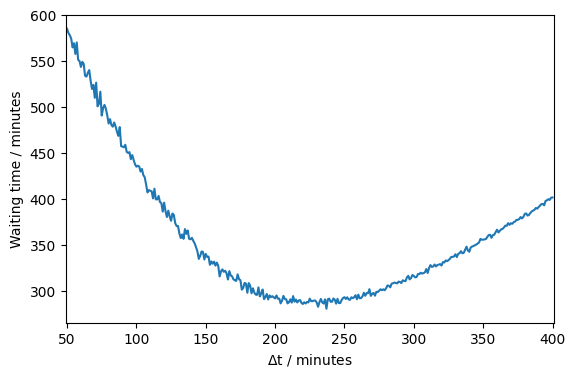

In [98]:
fig, ax = plt.subplots(figsize=(6.3, 4))

ax.plot(delta_t, wait_times)
ax.set(xlabel="$\Delta$t / minutes", ylabel="Waiting time / minutes", xlim=(min(delta_t)-1.0, max(delta_t)+1.0))

fig.tight_layout

if save_plots: 
    fig.savefig("wait_time_prop31.png", dpi = 600)

### 3.2 (13 points) The Rayleigh distribution is a PDF given by: $f(x) = \frac{x}{\sigma^{2}} exp(-\frac{0.5x^{2}}{\sigma^{2}})$, with x in [0;infinity].

By what method(s) would you generate random numbers (from uniform) according to f(x)?

In [99]:
# Transformation method
## 1. Make sure the PDF is normalized
## 2. Integrate f(x) to get F(x)
## 3. Invert F(x)

Generate N=1000 random numbers according to f(x) for sigma = 2, and plot these.

In [100]:
r = np.random
r.seed(42)

save_plots = True
N_points = 1000    # Number of random points to be generated

In [101]:
xmin = 0
xmax = np.inf
sigma = 2

In [102]:
# Test if PDF is normalized
def Rayleigh(x):
    return (x / sigma**2) * np.exp((-0.5 * x**2) / (sigma**2))

result = quad(Rayleigh, xmin, xmax)
if result[0] == 1:
    print(result)
    print('PDF is normalized')
else:
    print(result)
    print('PDF is NOT normalized')

(1.0, 2.1730298462088487e-09)
PDF is normalized


In [103]:
# Integrate f(x) from -infinity to x
def Rayleigh_sym(x):
    return (x / sigma**2) * exp((-0.5 * x**2) / (sigma**2))

x = Symbol('x')
xb = Symbol('xb')
F = integrate(Rayleigh_sym(xb), (xb,0,x))
print(F)

1.0 - 1.0*exp(-0.125*x**2)


In [104]:
# Invert F(x)
inv = solve(F - i, x)
print(inv)

[-2.82842712474619*sqrt(log(-1/(i - 1.0))), 2.82842712474619*sqrt(log(-1/(i - 1.0)))]


In [105]:
# Now produce random numbers using the inverse function found above
x_Rayleigh = 2.83*np.sqrt(np.log(-1/(r.uniform(size=N_points)-1)))

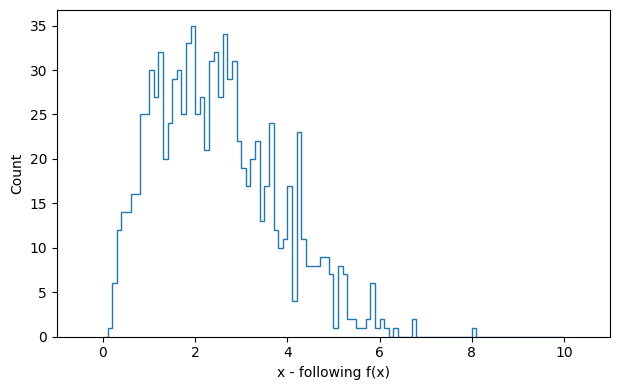

In [106]:
xmin = 0
xmax = 10
Nbins = 100
binwidth = (xmax - xmin) / Nbins

fig, ax = plt.subplots(figsize=(6.3, 4))
ax.hist(x_Rayleigh, bins=Nbins, range=(xmin, xmax), histtype='step', label='Histogram (generated)' )
ax.set(xlabel="x - following f(x)", ylabel="Count", xlim=(xmin-1.0, xmax+1.0))

fig.tight_layout()
fig.savefig('Rayleigh_hist.png', dpi = 150)

Fit this distribution of random numbers. How well can you determine sigma from the fit?

In [107]:
# Note that this pdf is NOT normalised!
# The "N" put outside is simply to minimize the (significant) correlations between the fit parameters.
def Rayleigh_pdf(x, N, sigma) :
    return N * ((x / sigma**2) * np.exp((-0.5 * x**2) / (sigma**2)))

fit_object = UnbinnedLH(Rayleigh_pdf, x_Rayleigh, extended=True)
minuit = Minuit(fit_object, N=1000, sigma=2)
minuit.errordef = 0.5
minuit.migrad()

c:\Users\nan25\OneDrive\Dokumenter\KU\5. år\AppStat\ProblemSet\../External_Functions\ExternalFunctions.py:169: VisibleDeprecationWarning: make_func_code is deprecated: Use of `func_code` attribute to declare parameters is deprecated. Use `_parameters` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])
C:\Users\nan25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\iminuit\util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4287                      │              Nfcn = 31               │
│ EDM = 1.1e-06 (Goal: 0.0001)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │  1.005e3  │  0.032e3  │            │            │         │         │       │
│ 1 │ sigma │   1.971   │   0.031   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │        N    sigma │
├───────┼───────────────────┤
│     N │ 1.01e+03  -2.9e-3 │
│ sigma │  -2.9e-3 0.000986 │
└───────┴───────────────────┘

In [108]:
if (not minuit.fmin.is_valid) :                                   # Check if the fit converged!
    print("  WARNING: The unbinned likelihood fit DID NOT converge!!!")
minuit_output = [minuit.fmin, minuit.params]       # Save the output parameters in case needed
for name in minuit.parameters:
    print("  Unbinned LLH Fit result: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))

  Unbinned LLH Fit result: N = 1005.01986 +/- 31.78164
  Unbinned LLH Fit result: sigma = 1.97057 +/- 0.03140


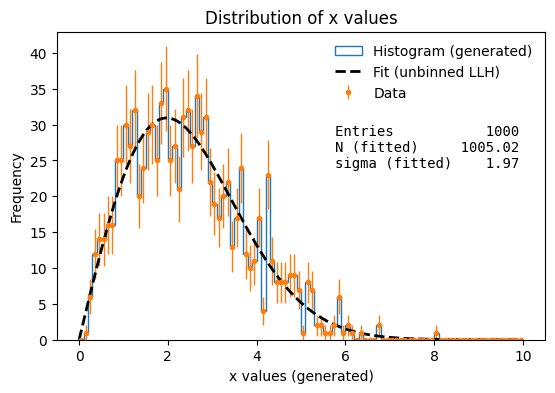

In [109]:
xmin = 0
xmax = 10
Nbins = 100
binwidth = (xmax - xmin) / Nbins

fig, ax = plt.subplots(figsize=(6.3, 4))
ax.hist(x_Rayleigh, bins=Nbins, range=(xmin, xmax), histtype='step', label='Histogram (generated)' )

y, bin_edges = np.histogram(x_Rayleigh, bins=Nbins, range=(xmin, xmax))
x = 0.5*(bin_edges[1:] + bin_edges[:-1])
sy = np.sqrt(y)      # This is the standard for histograms - bin entries are Poisson distributed!
hist_data = ax.errorbar(x, y, sy, fmt='.', linewidth=1, label="Data")
ax.set(xlabel="x values (generated)", ylabel = "Frequency", title = "Distribution of x values")

# Plot fit result on top of histograms:
x_ulfit = np.linspace(xmin, xmax, 1000)                                    # Create the x-axis for the plot of the fitted function
y_ulfit = binwidth * Rayleigh_pdf(x_ulfit, *minuit.values)
ax.plot(x_ulfit, y_ulfit, '--', color='black', linewidth=2, label='Fit (unbinned LLH)')
ax.legend(frameon = False)

# Define figure text
d = {'Entries': len(x_Rayleigh),
     'N (fitted)': minuit.values[0],
     'sigma (fitted)': minuit.values[1]
    }

# Plot figure text
text = nice_string_output(d, extra_spacing=1, decimals=2)
add_text_to_ax(0.57, 0.70, text, ax, fontsize=10)

if save_plots: 
    fig.savefig("Rayleigh.png", dpi = 600)

Test the 1/sqrt(N) scaling of the sigma fit uncertainty for N in [50; 5000].

In [110]:
r = np.random
r.seed(42)

save_plots = True
N_list = np.linspace(50, 5000, 4951)

In [111]:

sigma = np.zeros(len(N_list))
sigma_errors = np.zeros(len(N_list))

for i, N in enumerate(N_list):
    x_Rayleigh = 2.83*np.sqrt(np.log(-1/(r.uniform(size=int(N))-1)))

    def Rayleigh_pdf(x, N, sigma) :
        return N * ((x / sigma**2) * np.exp((-0.5 * x**2) / (sigma**2)))

    fit_object = UnbinnedLH(Rayleigh_pdf, x_Rayleigh, extended=True)
    minuit = Minuit(fit_object, N=N, sigma=2)
    minuit.errordef = 0.5
    minuit.migrad();

    sigma[i] += minuit.values[1]
    sigma_errors[i] += minuit.errors[1]

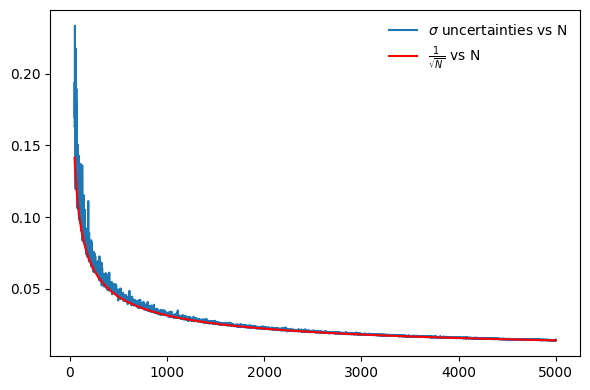

In [112]:
def test_func(x, N) :
    return N / np.sqrt(x)

fig, ax = plt.subplots(figsize = (6, 4))

ax.plot(N_list, sigma_errors, label = '$\sigma$ uncertainties vs N')
ax.plot(N_list, test_func(N_list, 1), label = r'$\frac{1}{\sqrt{N}}$ vs N', color = 'r')
ax.legend(frameon = False)

fig.tight_layout()
fig.savefig('scaling_test_esigma.png', dpi = 150)